# Goal

Optimizing marketing campaigns is one of the most common data science tasks. Among the many possible marketing tools, one of the most eﬃcient is using emails. Emails are great cause they are free and can be easily personalized. Email optimization involves personalizing the text and/or the subject, who should receive it, when should be sent, etc. Machine Learning excels at this. 

# Challenge Description
The marketing team of an e-commerce site has launched an email campaign. This site has email addresses from all the users who created an account in the past. They have chosen a random sample of users and emailed them. The email let the user know about a new feature implemented on the site. From the marketing team perspective, a success is if the user clicks on the link inside of the email. This link takes the user to the company site.

You are in charge of ﬁguring out how the email campaign performed and were asked the following questions: 

* What percentage of users opened the email and what percentage clicked on the link within the email? 
* The VP of marketing thinks that it is stupid to send emails to a random subset and in a random way. Based on all the information you have about the emails that were sent, can you build a model to optimize in future email campaigns to maximize the probability of users clicking on the link inside the email? 
* By how much do you think your model would improve click through rate ( deﬁned as # of users who click on the link / total users who received the email). 
* How would you test that? Did you ﬁnd any interesting pattern on how the email campaign performed for diﬀerent segments of users? Explain.

# Data

The 3 tables are:  
## **"email_table" - info about each email that was sent**
  
Columns:
* **email_id** : the Id of the email that was sent. It is unique by email
* **email_text** : there are two versions of the email: one has "long text" (i.e. has 4 paragraphs) and one has "short text" (just 2 paragraphs)
* **email_version** : some emails were "personalized" (i.e. they had the name of the user receiving the email in the incipit, such as "Hi John,"), while some emails were "generic" (the incipit was just "Hi,").
* **hour** : the user local time when the email was sent.
* **weekday** : the day when the email was sent.
* **user_country** : the country where the user receiving the email was based. It comes from the user ip address when she created the account.
* **user_past_purchases** : how many items in the past were bought by the user receiving the email

## **"email_opened_table" -  the id of the emails that were opened at least once.**
Columns:
* **email_id** : the id of the emails that were opened, i.e. the user clicked on the email and, supposedly, read it.

## **"link_clicked_table" -  the id of the emails whose link inside was clicked
at least once. This user was then brought to the site.**

Columns:
* **email_id** : if the user clicked on the link within the email, then the id of the email shows up on this table.

# Analysis

## Load library and data

In [256]:
import itertools
import _pickle as cPickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
from sklearn.feature_selection import chi2,f_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report,roc_curve,precision_score,recall_score,auc,precision_recall_curve,plot_confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore', category=UserWarning)

seed = 9999
plt.style.use('ggplot')
%matplotlib inline

In [22]:
emails = pd.read_csv("email_table.csv",index_col="email_id")
emails.head()

,email_text,email_version,hour,weekday,user_country,user_past_purchases
email_id,,,,,,
85120,short_email,personalized,2,Sunday,US,5
966622,long_email,personalized,12,Sunday,UK,2
777221,long_email,personalized,11,Wednesday,US,2
493711,short_email,generic,6,Monday,UK,1
106887,long_email,generic,14,Monday,US,6


Since we need convert features into numerical in the later analysis. I decided to simplify the dataframe first.  
And then assemble emails’ response together

In [24]:
emails = pd.read_csv("email_table.csv",index_col="email_id")
emails.rename(columns={'user_past_purchases':'purchases','user_country':'country'},inplace=True)
weekday2index = {"Monday":1,"Tuesday":2,"Wednesday":3,"Thursday":4,"Friday":5,"Saturday":6,"Sunday":7}
emails["weekday"] = emails.weekday.map(weekday2index)
emails['is_personalized']=(emails.email_version == "personalized").astype(np.int)
emails['long_email']=(emails.email_text=="long_email").astype(np.int)
emails=emails.drop(columns=['email_text','email_version'])
emails["response"] = "received"
open_users = pd.read_csv("email_opened_table.csv").email_id
emails.loc[open_users,"response"] = "opened"

click_users = pd.read_csv("link_clicked_table.csv").email_id
emails.loc[click_users,"response"] = 'clicked'
emails.head()

,hour,weekday,country,purchases,is_personalized,long_email,response
email_id,,,,,,,
85120,2,7,US,5,1,0,received
966622,12,7,UK,2,1,1,clicked
777221,11,3,US,2,1,1,received
493711,6,1,UK,1,0,0,received
106887,14,1,US,6,0,1,received


## What percentage of users opened the email and what percentage clicked on the link within the email?

In [29]:
rslt_dist = emails.response.value_counts(normalize=True)
pd.DataFrame(rslt_dist).rename(columns={'response':'Percentage'})

10.39% of users opened the email
2.12% of users clicked the link


In [31]:
print("among all users received emails, {:.2f}% of users opened the email".format((1 - rslt_dist.received) * 100))
print("among all users received emails, {:.2f}% of users clicked the link".format(rslt_dist.clicked * 100))

among all users received emails, 10.39% of users opened the email
among all users received emails, 2.12% of users clicked the link


In [94]:
def count_result_ratio(df):
    counts = df.response.value_counts(normalize=True)
    counts['total'] = df.shape[0]
    return counts

def grp_count_plotbar(key):
    grpresult = emails.groupby(key).apply(count_result_ratio)
    # grpresult.loc[:,["received","opened",'clicked']].plot(kind='bar')
    #grpresult= pd.DataFrame(grpresult)
    grpresult.loc[:,['clicked']].plot(kind='bar',title='click ratio vs. {}'.format(key))
    plt.xticks(rotation=0)
    plt.ylabel('click ratio')
    return grpresult

## Explore the data

In [62]:
resp_lb_encoder = LabelEncoder()
cnty_lb_encoder = LabelEncoder()

X = emails.copy()
y = resp_lb_encoder.fit_transform(X.response)
del X["response"]

feat_names = ["hour","weekday","country","purchases","long_email","is_personalized"]
X = X.loc[:,feat_names]
X["country"] = cnty_lb_encoder.fit_transform(X.country)

chi2scores,_ = chi2(X,y)
fscores,_ = f_classif(X,y)

feat_scores = pd.DataFrame({"chi2scores":chi2scores,"fscores":fscores},index=feat_names)
feat_scores.sort_values(by='chi2scores',ascending=False)

,chi2scores,fscores
purchases,3448.795660,663.388596
country,378.554465,435.696911
is_personalized,316.752872,317.427444
weekday,210.006087,105.002643
hour,147.815921,33.992047
long_email,80.632477,81.209295


from the test result, we can know that

* **important features**: previous purchase counts, user’s country, email’s version (personal or general)
* not so important features maybe include: weekday, email’s text (short or long), hour to send the ema

### Number of items purchased v.s. Response

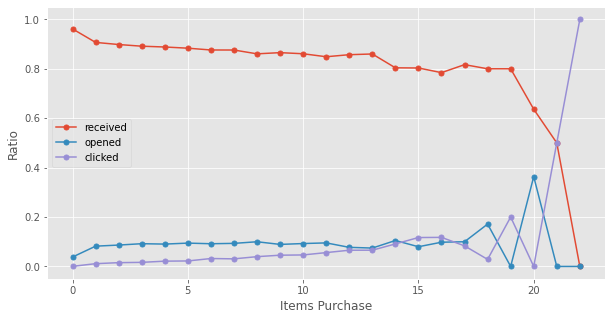

In [60]:
email_grpby_purchase = emails.groupby("purchases").apply(count_result_ratio).unstack()
email_grpby_purchase.fillna(value=0,inplace=True)

fig,ax =plt.subplots(nrows=1,ncols=1,figsize=(10, 5))
plt.plot(email_grpby_purchase.loc[:,["received","opened",'clicked']],marker='o',markersize=5)
plt.legend(["received","opened",'clicked'])
ax.set_xlabel("Items Purchase")
ax.set_ylabel('Ratio')
plt.show()

from above plot, we can know, the more items a certain user purchased previously, the more likely that user will open the email or click the link.

### Country v.s. Response

response,received,opened,clicked,total
country,,,,
ES,0.960570,0.031103,0.008327,9967.0
FR,0.958779,0.033217,0.008004,9995.0
UK,0.879282,0.096043,0.024675,19939.0
US,0.880481,0.095160,0.024360,60099.0


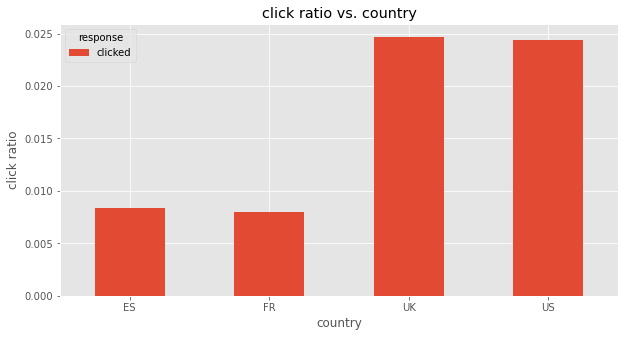

In [74]:
grp_count_plotbar('country')

from above plots, we see that, ‘open percentage’ and ‘click percentage’ is much higher (nearly 3 times) in UK and US than in France and Spain.

**This may be the translation issue. I guess the emails are written in English, which is unreadable to some non-English-speaking users, which cause the low ‘click ratio’ in non-English-speaking countries.**



### Personalized Email v.s. Response

response,received,opened,clicked,total
is_personalized,,,,
0,0.920034,0.064829,0.015137,50209.0
1,0.871864,0.100842,0.027294,49791.0


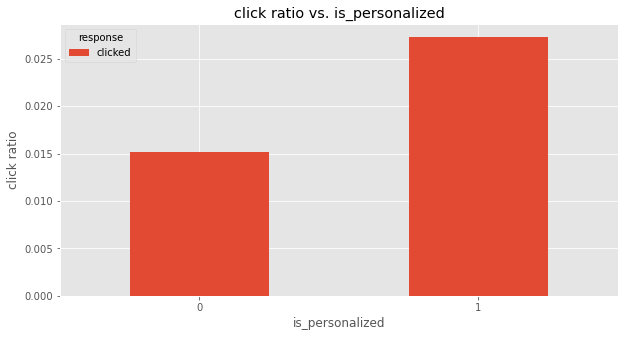

In [75]:
grp_count_plotbar('is_personalized')

‘personalized email’ has higher ‘click ratio’ than ‘general email’. this is very easy to understand. Having user's name in the recipient will make uses feel that they're ‘important’ to the company, other than some ordinary people which the company don’t bother to remember his name.

### weekday vs. response

response,received,opened,clicked,total
weekday,,,,
1,0.883590,0.093504,0.022906,14363.0
2,0.879092,0.096019,0.024889,14143.0
3,0.879296,0.093084,0.027620,14084.0
4,0.881348,0.094207,0.024445,14277.0
5,0.925019,0.060944,0.014037,14177.0
6,0.912005,0.070149,0.017846,14569.0
7,0.911448,0.071801,0.016751,14387.0


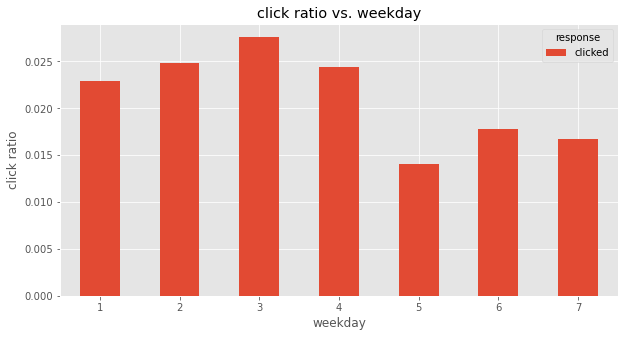

In [91]:
grp_count_plotbar('weekday')

Friday, Saturday, Sunday have obviously lower ‘click ratio’ than Monday to Thursday. People normally don’t process emails during weekends.



### email length vs. response

response,received,opened,clicked,total
long_email,,,,
0,0.883698,0.092430,0.023872,49724.0
1,0.908266,0.073196,0.018538,50276.0


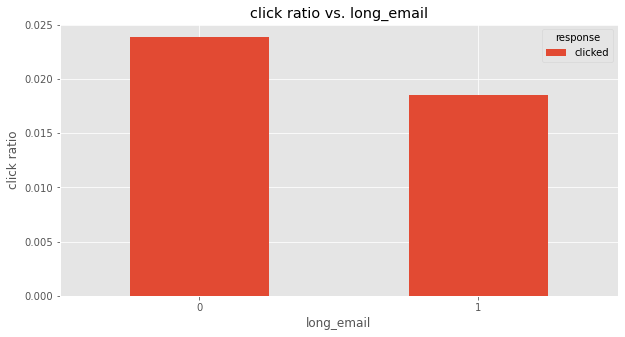

In [95]:
grp_count_plotbar('long_email')

From graph above, we can tell that users tends to open and click short email. I guess users don't like to read long paragraph emails especially advertising emails. But the difference is slight.

### sending hour vs. response

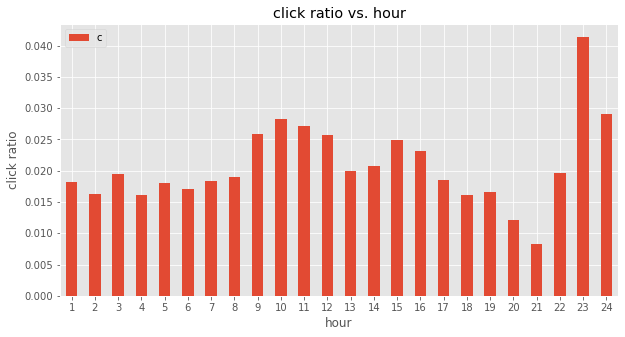

In [115]:
a=emails.groupby('hour').apply(count_result_ratio)
a= pd.DataFrame(a).unstack()
a[('response',  'clicked')].plot(kind='bar',title='click ratio vs. {}'.format('hour'))
plt.xticks(rotation=0)
plt.ylabel('click ratio')
plt.legend(labels='clicked')
plt.show()

Although from above plot, it seems ‘sending hour’ has some impact on ‘clicked ratio’. however, that may be caused by much fewer examples in late hours. also according to statistical test‘s result, I don’t think ‘sending hour’ is an important feature, and won’t include it in my model.

### EDA Conclusion


* The more item a certain user purchased in the past, the more likely that user will click the link
* Users from English-speaking coutries are more likely to click the link, which may be caused by some translation issue.
* Personalized email is more likely to be opened and clicked
* Emails sent at weekends is less likely to be opened and clicked
* Sending hour and #Paragraphs are not very important features to affect click rate


# Model Development

## Random Forest

In [275]:
del X
X = emails.copy()
X = X.loc[:,["country","purchases","long_email","is_personalized"] ]

# create new feature
X['is_weekend'] = (emails.weekday>=5).astype(int)
# One-Hot-Encode 'country' feature
X = pd.get_dummies(X,columns=["country"],drop_first=True)
# prepare the label
y = (emails.response == 'clicked').astype(int)
X.sample(5)# get a feeling about current data


100000

In [276]:
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.3,random_state = 1234)
print( 'Train set shape: {}, positive ratio={:.3f}'.format(Xtrain.shape,ytrain.mean()))
print( 'Test set shape: {}, positive ratio={:.3f}'.format(Xtest.shape,ytest.mean()))

Train set shape: (70000, 7), positive ratio=0.021
Test set shape: (30000, 7), positive ratio=0.021


In [277]:
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=5000, n_features=4,n_informative=2, n_redundant=0,random_state=9999, shuffle=False)
clf = RandomForestClassifier(max_depth=3, random_state=0)

In [278]:
clf.fit(Xtrain, ytrain)

RandomForestClassifier(max_depth=3, random_state=0)

In [279]:
feature_importance_table=pd.DataFrame(zip(clf.feature_names_in_,clf.feature_importances_),columns=['Feature','Importance']).sort_values('Importance',ascending=False)
feature_importance_table.reset_index(drop=True)

,Feature,Importance
0,purchases,0.576823
1,is_personalized,0.185608
2,is_weekend,0.086991
3,country_FR,0.065478
4,country_US,0.047401
5,country_UK,0.019200
6,long_email,0.018498


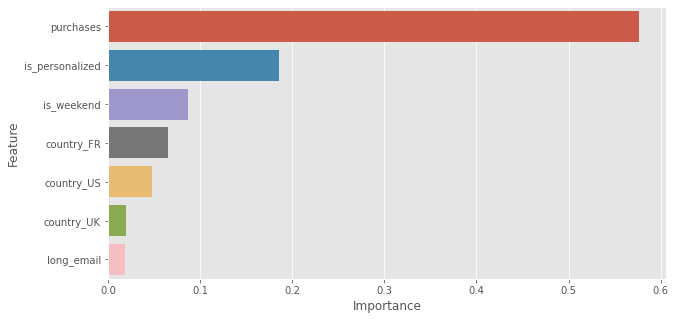

In [280]:
fig,ax=plt.subplots(figsize=(10,5))
sns.barplot(x='Importance',y='Feature',data=feature_importance_table)
plt.show()

In [281]:
print(classification_report(ytest,y_predict))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     29361
           1       0.00      0.00      0.00       639

    accuracy                           0.98     30000
   macro avg       0.49      0.50      0.49     30000
weighted avg       0.96      0.98      0.97     30000



since the data is highly imbalanced (positive examples is only 2% of the total examples), if using default probability threshold (0.5), the model just classify every example as negative, so we need to plot the ROC curve and choose a better probability threshold.

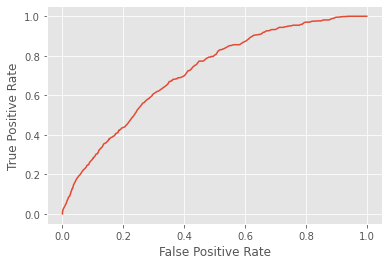

In [284]:
y_pred_proba = clf.predict_proba(Xtest)[::,1]
fpr, tpr, _ = roc_curve(ytest,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [305]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(Xtrain, ytrain)

threshold = 0.2

predicted_proba = random_forest.predict_proba(Xtest)
predicted = (predicted_proba [:,1] >= threshold).astype('int')

accuracy = accuracy_score(ytest, predicted)
print(round(accuracy,4,)*100, "%")

97.69 %


In [306]:
print(classification_report(ytest, predicted))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     29361
           1       0.13      0.02      0.03       639

    accuracy                           0.98     30000
   macro avg       0.56      0.51      0.51     30000
weighted avg       0.96      0.98      0.97     30000



## Xgboost

Due to time limitation, I will just train one GBM model.

If given sufficient time, I will apply following strategies to improve the model:

build multiple models, and ensemble them (average or stacking) to improve the prediction performance.
try more hyper-parameters to find better ones.

In [128]:
train_matrix = xgb.DMatrix(Xtrain,ytrain)
test_matrix = xgb.DMatrix(Xtest)

In [168]:
params = {}
params['objective'] = 'binary:logistic'  # output probabilities
params['eval_metric'] = 'auc'
params["nrounds"] = 300
params["early_stopping_rounds"] = 30
# params['min_child_weight'] = 2
params['max_depth'] = 6
params['eta'] = 0.1
params["subsample"] = 0.8
params["colsample_bytree"] = 0.8

cv_results = xgb.cv(params,train_matrix,
                    num_boost_round = params["nrounds"],
                    nfold = params.get('nfold',5),
                    metrics = params['eval_metric'],
                    early_stopping_rounds = params["early_stopping_rounds"],
                    verbose_eval = False,
                    seed = seed)

[21:27:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "early_stopping_rounds", "nrounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:27:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "early_stopping_rounds", "nrounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:27:04] WARNING: /Users/runner/work/xgboost/xgboost/p

In [169]:
n_best_trees = cv_results.shape[0]
print("best number of trees: {}".format(n_best_trees))

best number of trees: 55


In [173]:
watchlist = [(train_matrix, 'train')]
gbt = xgb.train(params, train_matrix, n_best_trees,watchlist,verbose_eval=0)

[21:28:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "early_stopping_rounds", "nrounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




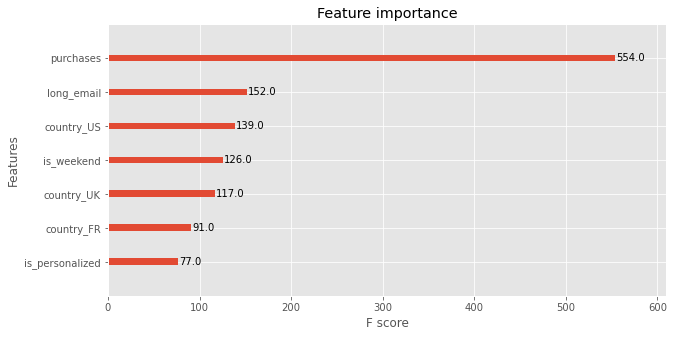

In [152]:
xgb.plot_importance(gbt)
plt.show()

Above feature importance match the result from explorary analysis.


## Plot ROC curve and choose better probability threshold
since the data is highly imbalanced (positive examples is only 2% of the total examples), if using default probability threshold (0.5), the model just classify every example as negative, so we need to plot the ROC curve and choose a better probability threshold.

But ROC cannot be plot on either training set or test set. so I split the original train set into ‘training’ and ‘validation’ sets, re-train on ‘training set’ and plot ROC on ‘validation set’.

In [159]:
def validation_roc():
    Xtrain_only,Xvalid,ytrain_only,yvalid = train_test_split(Xtrain,ytrain,test_size=0.2,random_state=seed)

    train_only_matrix = xgb.DMatrix(Xtrain_only,ytrain_only)
    valid_matrix = xgb.DMatrix(Xvalid)

    # retrain on training set
    gbt_train_only = xgb.train(params, train_only_matrix, n_best_trees)

    # predict on validation set
    yvalid_probas = gbt_train_only.predict(valid_matrix, ntree_limit=n_best_trees)

    d = {}
    d['FPR'],d['TPR'],d['Threshold'] = roc_curve(yvalid,yvalid_probas)
    return pd.DataFrame(d)

[21:29:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "early_stopping_rounds", "nrounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




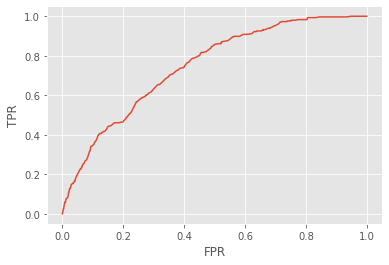

In [175]:
roc_results = validation_roc()
_ = plt.figure()
plt.plot(roc_results.FPR,roc_results.TPR)
plt.xlabel("FPR")
plt.ylabel('TPR')
plt.show()

In [177]:
roc_results.loc[(roc_results.TPR > 0.6) & (roc_results.TPR < 0.65),:]

,FPR,TPR,Threshold
193,0.278293,0.603390,0.027183
194,0.278657,0.603390,0.027089
195,0.282744,0.610169,0.027065
196,0.282816,0.610169,0.026749
197,0.291062,0.616949,0.026713
198,0.291572,0.616949,0.026185
199,0.301934,0.637288,0.025885
200,0.302371,0.637288,0.025824
201,0.302663,0.637288,0.025737


In [180]:
pos_prob_threshold = 0.029118

def adjust_predict(matrix):
    y_probas = gbt.predict(matrix, ntree_limit=n_best_trees)
    return (y_probas > pos_prob_threshold).astype(int)
ytrain_pred = adjust_predict(train_matrix)
print(classification_report(ytrain,ytrain_pred))

              precision    recall  f1-score   support

           0       0.99      0.75      0.86     68520
           1       0.05      0.60      0.09      1480

    accuracy                           0.75     70000
   macro avg       0.52      0.68      0.47     70000
weighted avg       0.97      0.75      0.84     70000



In [182]:
ytest_pred = adjust_predict(test_matrix)
print(classification_report(ytest,ytest_pred))

              precision    recall  f1-score   support

           0       0.99      0.76      0.86     29361
           1       0.04      0.51      0.08       639

    accuracy                           0.75     30000
   macro avg       0.51      0.63      0.47     30000
weighted avg       0.97      0.75      0.84     30000



In [183]:
print("test precision: {:.2f}%".format(precision_score(ytest,ytest_pred) * 100))
print ("test recall: {:.2f}%".format(recall_score(ytest,ytest_pred) * 100))

test precision: 4.33%
test recall: 50.70%


## Answer question 2 and question 3’s first part
### The VP of marketing thinks that it is stupid to send emails to a random subset and in a random way. Based on all the information you have about the emails that were sent, can you build a model to optimize in future email campaigns to maximize the probability of users clicking on the link inside the email?

### By how much do you think your model would improve click through rate ( deﬁned as # of users who click on the link / total users who received the email). How would you test that?

I have build a Gradient Boosting Tree model in previous section which predicts whether a user will click the link or not. Then the new email campaign strategy will be: only send email to users which my GBM model predicts positive.

In [186]:
n_emails_old_sent = ytest_pred.shape[0]
n_emails_new_sent = ytest_pred.sum()
saving_percentage = 100 - n_emails_new_sent * 100.0/n_emails_old_sent
pd.Series({'# of emails sent in old way': n_emails_old_sent,
           '# of emails sent in new way': n_emails_new_sent,
           'saving percentage (%)': saving_percentage})

# of emails sent in old way    30000.00
# of emails sent in new way     7485.00
saving percentage (%)             75.05
dtype: float64

my model only need to send 25% of the old email amount, saving 75% amount.
4.33% of the receiver will open email and click the link. compare with old strategy, whose click rate is 2.12% , my new strategy can double the click rate.


### By how much do you think your model would improve click through rate ( deﬁned as # of users who click on the link / total users who received the email). How would you test that?

To test my conclusion, we need to perform a A/B test:

* Randomly assign users to two groups, Control group and Experiment group.  
* In Control group, still use the old email-campaign strategy, i.e., just send emails to all users in Control group.  
* In Experiment group, use my model to predict whether the user will click the link or not. and only send emails to those users whose predictive result is positive.
* Then we preform a one-tail unpaired t-test to test whether Experiement group’s population proportion is higher than Control group’s population proportion.